In [2]:
import pandas as pd

def load_data(file_path):
    """
    Load data from a CSV file.
    
    Parameters:
    file_path (str): Path to the CSV file.
    
    Returns:
    pd.DataFrame: Loaded data as a DataFrame.
    """
    return pd.read_csv(file_path)


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def find_best_fit(training_data, ideal_functions):
    """
    Find the best-fitting ideal functions for each column in the training data.
    
    Parameters:
    training_data (pd.DataFrame): DataFrame containing the training data.
    ideal_functions (pd.DataFrame): DataFrame containing the ideal functions.
    
    Returns:
    dict: Dictionary mapping each training column to its best-fitting ideal function and RMSE.
    """
    best_fits = {}
    
    for train_col in training_data.columns[1:]:
        min_rmse = float('inf')
        best_func = None
        
        for ideal_col in ideal_functions.columns[1:]:
            model = LinearRegression()
            model.fit(training_data[['x']], training_data[train_col])
            predictions = model.predict(ideal_functions[['x']])
            rmse = mean_squared_error(ideal_functions[ideal_col], predictions, squared=False)
            
            if rmse < min_rmse:
                min_rmse = rmse
                best_func = ideal_col
        
        best_fits[train_col] = (best_func, min_rmse)
    
    return best_fits


In [4]:
def map_test_data_to_ideal(test_data, training_data, ideal_functions, best_fits):
    """
    Map test data to the best-fitting ideal functions and calculate deviations.
    
    Parameters:
    test_data (pd.DataFrame): DataFrame containing the test data.
    training_data (pd.DataFrame): DataFrame containing the training data.
    ideal_functions (pd.DataFrame): DataFrame containing the ideal functions.
    best_fits (dict): Dictionary mapping each training column to its best-fitting ideal function and RMSE.
    
    Returns:
    pd.DataFrame: DataFrame containing the test data with mapped ideal functions and deviations.
    """
    mapped_test_data = test_data.copy()
    mapped_test_data['Ideal_Function'] = ''
    mapped_test_data['Deviation'] = 0.0
    
    for train_col, (ideal_col, _) in best_fits.items():
        model = LinearRegression()
        model.fit(training_data[['x']], ideal_functions[ideal_col])
        predictions = model.predict(test_data[['x']])
        mapped_test_data['Ideal_Function'] = ideal_col
        mapped_test_data['Deviation'] = abs(mapped_test_data['y'] - predictions)
    
    return mapped_test_data


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data(training_data, ideal_functions):
    """
    Visualize training data and ideal functions.
    
    Parameters:
    training_data (pd.DataFrame): DataFrame containing the training data.
    ideal_functions (pd.DataFrame): DataFrame containing the ideal functions.
    """
    plt.figure(figsize=(20, 10))
    
    # Plot training data
    for col in training_data.columns[1:]:
        plt.scatter(training_data['x'], training_data[col], label=col)
    
    # Plot ideal functions
    for col in ideal_functions.columns[1:]:
        plt.plot(ideal_functions['x'], ideal_functions[col], label=col)
    
    plt.title('Training Data and Ideal Functions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_rmse_comparison(rmse_values):
    """
    Visualize the RMSE values for each training data column.
    
    Parameters:
    rmse_values (dict): Dictionary containing RMSE values for each training data column.
    """
    plt.figure(figsize=(14, 7))
    plt.bar(rmse_values.keys(), rmse_values.values(), color='blue', alpha=0.7)
    
    plt.title('RMSE Comparison for Training Data Columns')
    plt.xlabel('Training Data Columns')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()


In [6]:
import sqlite3

def store_results_in_db(mapped_test_data):
    """
    Store the mapped test data with deviations in an SQLite database.
    
    Parameters:
    mapped_test_data (pd.DataFrame): DataFrame containing the mapped test data with deviations.
    """
    conn = sqlite3.connect('results.db')
    mapped_test_data.to_sql('Mapped_Test_Data', conn, if_exists='replace', index=False)
    conn.close()


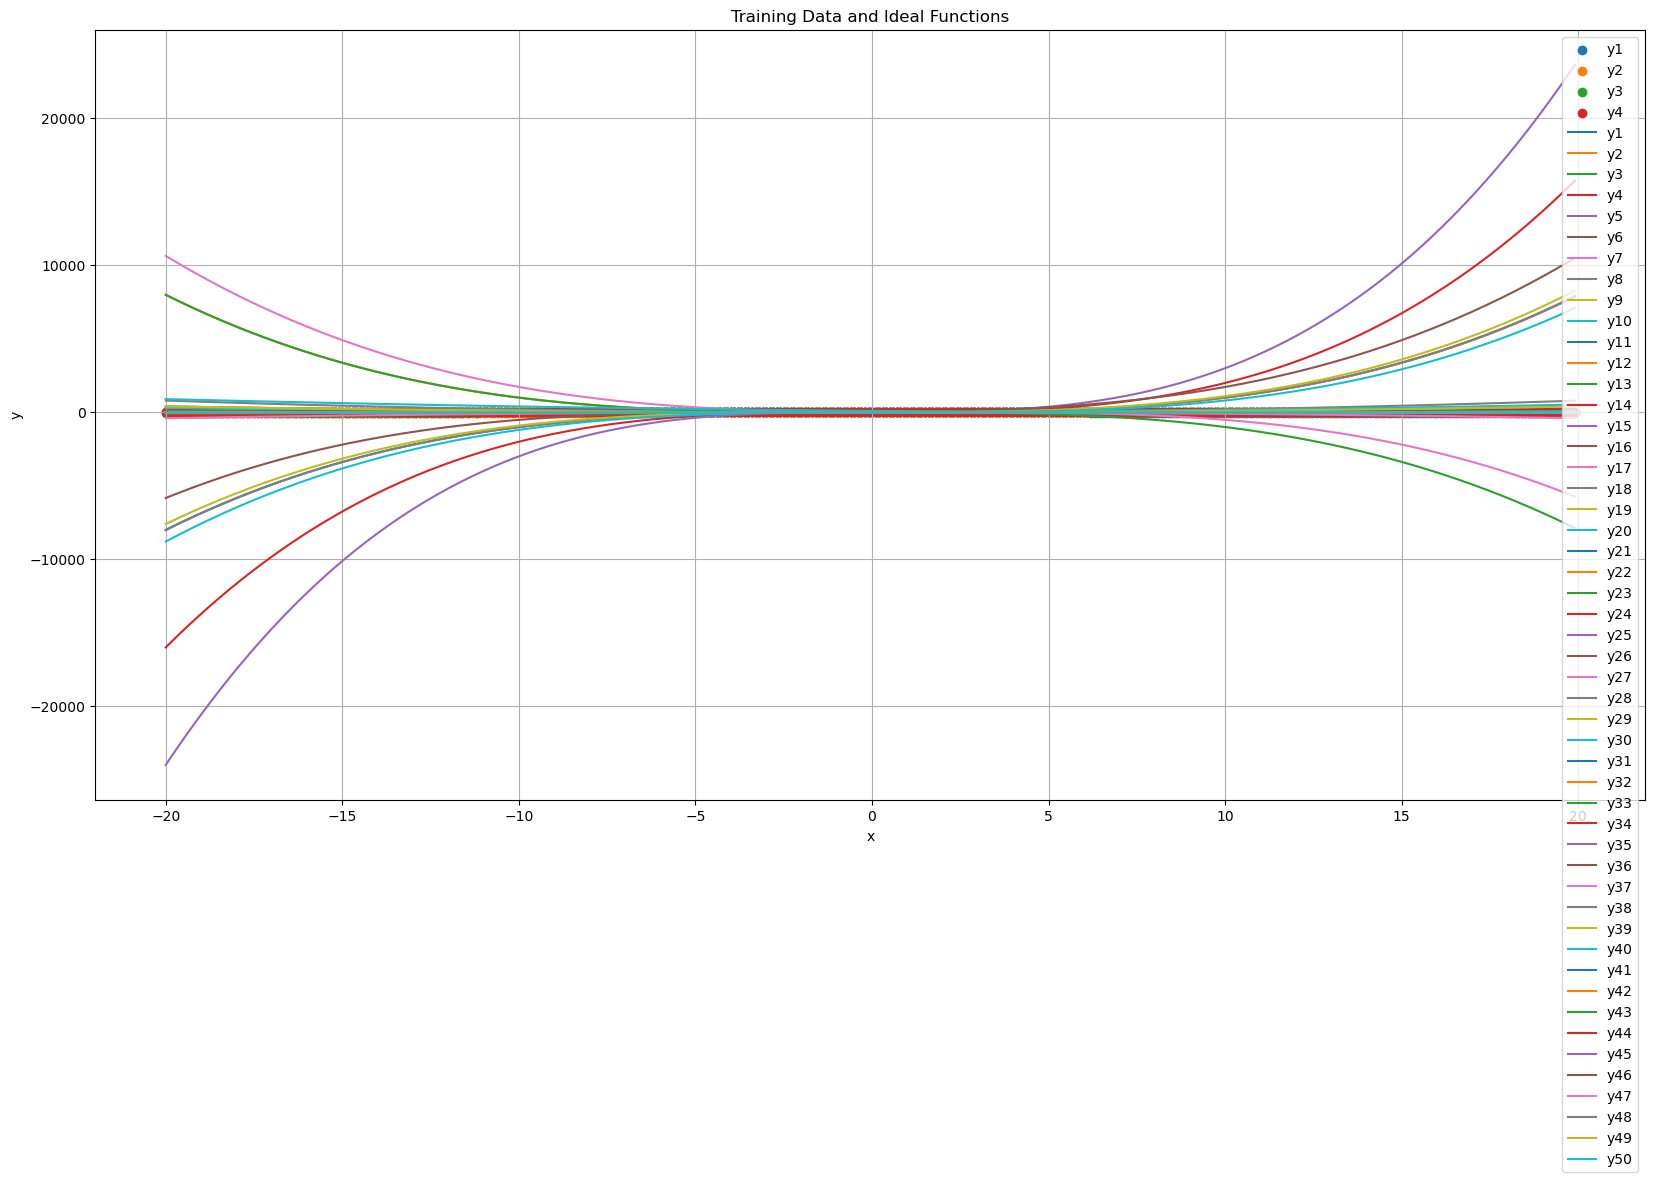

Best Fit Ideal Functions and RMSE Values:
y1 -> y42 with RMSE: 0.3573
y2 -> y41 with RMSE: 0.3500
y3 -> y11 with RMSE: 0.0046
y4 -> y44 with RMSE: 0.0285


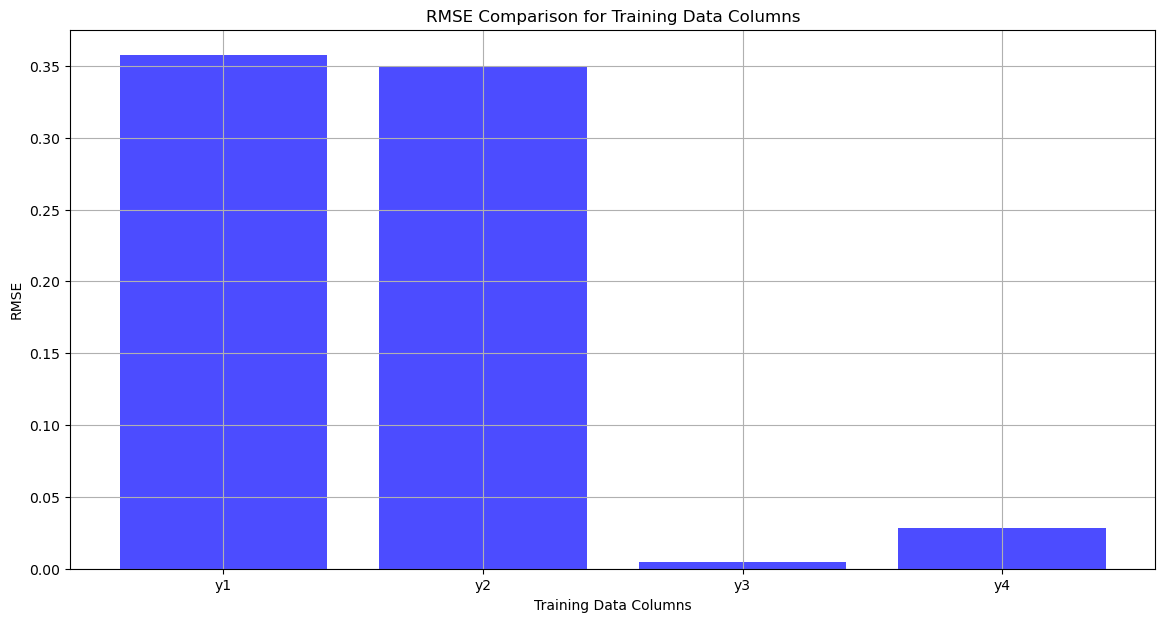

In [7]:
def main():
    # Load data
    training_data = load_data('train.csv')
    ideal_functions = load_data('ideal.csv')
    test_data = load_data('test.csv')
    
    # Visualize training data and ideal functions
    visualize_data(training_data, ideal_functions)
    
    # Identify best ideal functions
    best_fits = find_best_fit(training_data, ideal_functions)
    
    # Print best fits and their RMSE values
    print("Best Fit Ideal Functions and RMSE Values:")
    for train_col, (ideal_col, rmse) in best_fits.items():
        print(f"{train_col} -> {ideal_col} with RMSE: {rmse:.4f}")
    
    # Visualize RMSE comparison
    rmse_values = {train_col: rmse for train_col, (_, rmse) in best_fits.items()}
    visualize_rmse_comparison(rmse_values)
    
    # Map test data to ideal functions
    mapped_test_data = map_test_data_to_ideal(test_data, training_data, ideal_functions, best_fits)
    
    # Store results in SQLite database
    store_results_in_db(mapped_test_data)

if __name__ == "__main__":
    main()


In [8]:
import unittest

class TestDataLoading(unittest.TestCase):
    def test_load_data(self):
        data = load_data('train.csv')
        self.assertIsInstance(data, pd.DataFrame)
        self.assertFalse(data.empty)
        self.assertIn('x', data.columns)
        
class TestModelFunctions(unittest.TestCase):
    def setUp(self):
        self.training_data = load_data('train.csv')
        self.ideal_functions = load_data('ideal.csv')
        
    def test_find_best_fit(self):
        best_fits = find_best_fit(self.training_data, self.ideal_functions)
        self.assertIsInstance(best_fits, dict)
        self.assertGreater(len(best_fits), 0)
        
    def test_map_test_data_to_ideal(self):
        best_fits = find_best_fit(self.training_data, self.ideal_functions)
        test_data = load_data('test.csv')
        mapped_test_data = map_test_data_to_ideal(test_data, self.training_data, self.ideal_functions, best_fits)
        self.assertIsInstance(mapped_test_data, pd.DataFrame)
        self.assertIn('Ideal_Function', mapped_test_data.columns)
        self.assertIn('Deviation', mapped_test_data.columns)

if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


.C:\Users\adity\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

C:\Users\adity\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

.C:\Users\adity\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

C:\Users\adity\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\Users\adity\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

C:\Users\adity\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

.
----------------------------------------------------------------------
Ran 3 tests in 0.568s

OK
